In [1]:
from functools import partial

import numpy as np
import cv2

from ipynb.fs.full.quantumsystem import System, HyperSystem, qs, FloatSystem
from ipynb.fs.full.DamageSystem import Armor
from ipynb.fs.full.MovementSystem import Elevation, XYLocation, Movement, Footprint
from ipynb.fs.full.FactionSystem import Faction

In [2]:
class StructureType(System):
    """ High level type of structure """

@StructureType.sd
@Faction.sd
@Armor.sd
@Elevation.sd
@XYLocation.sd
@Footprint.sd
class Structure(HyperSystem):
    @classmethod
    def get_by_structure_type(cls, structureType):
        return [r[0] for r in qs.get(edge_name=[StructureType], terminant=structureType)]
    
    @classmethod
    def buildStructureFactory(cls, **systemDefaults):
        def newStructureFactory(structureName, faction="Unaligned", elevation=5, xylocation=None, footprint=None):
            systemDefaults["Faction"] = faction
            systemDefaults["Elevation"] = elevation
            systemDefaults["XYLocation"] = xylocation or [0, 0]
            systemDefaults["Footprint"] = footprint or Footprint.example_footprint
            return cls(structureName, **systemDefaults)
        return newStructureFactory

In [3]:
StructureFactories = {
    "Factory": Structure.buildStructureFactory(
        StructureType="Factory",
        XYLocation=[0, 0],
        Elevation=5,
        Armor={
            "ArmorPlating": "9",
            "ArmorPlatingDamage": 0,
            "ArmorStructural": "7",
            "ArmorStructuralDamage": 0
        },
        Faction="Unaligned"
    ),
    "Apartment Tower": Structure.buildStructureFactory(
        StructureType="Apartment Tower",
        XYLocation=[0, 0],
        Elevation=10,
        Armor={
            "ArmorPlating": "9",
            "ArmorPlatingDamage": 0,
            "ArmorStructural": "7",
            "ArmorStructuralDamage": 0
        },
        Faction="Unaligned"
    )
}

In [4]:
class TerrainDifficulty(FloatSystem):
    """ Terrain Difficulty from in the XY plane """

In [9]:
@Footprint.sd
@Elevation.sd
@XYLocation.sd
@TerrainDifficulty.sd
class Terrain(HyperSystem):
    @classmethod
    def buildTerrainFactory(cls, **systemDefaults):
        return partial(
            cls,
            **systemDefaults)
    
    @classmethod
    def buildTerrainFactory(cls, **systemDefaults):
        def newTerrainFactory(terrainName, elevation=5, difficulty=1, xylocation=None, footprint=None):
            systemDefaults["Elevation"] = elevation
            systemDefaults["TerrainDifficulty"] = difficulty
            systemDefaults["XYLocation"] = xylocation if xylocation is None else [0, 0]
            systemDefaults["Footprint"] = footprint if footprint is None else Footprint.example_footprint
            return cls(terrainName, **systemDefaults)
        return newTerrainFactory


TerrainFactories = {
    "UniformElevation": Terrain.buildTerrainFactory(
        Elevation=10,
        XYLocation=[0, 0]
    )
}

In [10]:
def buildElevationOverlays() -> dict[int, np.array]:
    elevationOverlays = {}
    elevationEntities = Terrain.entities() + Structure.entities()
    existingEntities = getattr(buildElevationOverlays, "elevationEntities", {})
    if elevationEntities == existingEntities:
        return getattr(buildElevationOverlays, "elevationOverlays")
    for entity in elevationEntities:
        elevation = Elevation(entity).terminant
        footprint = Footprint(entity).terminant
        if elevation in elevationOverlays:
            elevationOverlays[elevation] = cv2.drawContours(elevationOverlays[elevation], [footprint], -1, 255, -1)
        else:
            elevationOverlays[elevation] = cv2.drawContours(np.zeros([1200, 1200, 1], dtype="uint8"), [footprint], -1, 255, -1)
    buildElevationOverlays.elevationEntities = elevationEntities
    buildElevationOverlays.elevationOverlays = elevationOverlays
    return elevationOverlays

In [11]:
def buildDifficultyOverlays() -> dict[int, np.array]: 
    difficultyOverlays = {}
    difficultyEntities = Terrain.entities()
    existingEntities = getattr(buildDifficultyOverlays, "difficultyEntities", None)
    if difficultyEntities == existingEntities:
        return getattr(buildDifficultyOverlays, "difficultyOverlays")
    for entity in difficultyEntities:
        difficulty = TerrainDifficulty(entity).terminant + 1
        footprint = Footprint(entity).terminant
        if difficulty in difficultyOverlays:
            difficultyOverlays[difficulty] = cv2.drawContours(difficultyOverlays[difficulty], [footprint], -1, 255, -1)
        else:
            difficultyOverlays[difficulty] = cv2.drawContours(np.zeros([1200, 1200, 1], dtype="uint8"), [footprint], -1, 255, -1)
    setattr(buildDifficultyOverlays, "difficultyEntities", difficultyEntities)
    setattr(buildDifficultyOverlays, "difficultyOverlays", difficultyOverlays)
    return difficultyOverlays

Received expected exception: Failed to retrieve MovementSpeed relationship on ApartmentB


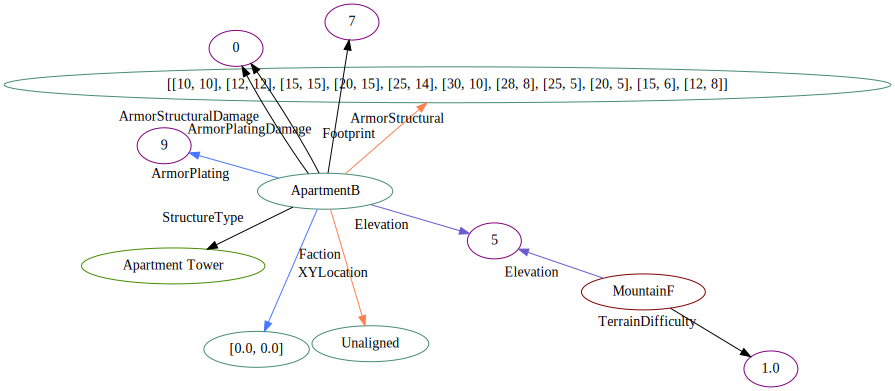

In [12]:
if __name__ == "__main__":
    from IPython.display import display
    qs.reset()

    StructureFactories['Apartment Tower']('ApartmentB')
    assert Structure.get_by_structure_type("Apartment Tower") == ['ApartmentB']
    try:
        Movement.move(entity="ApartmentB", delta=[1, 0, 0])
    except Movement.MovementSpeed.RelationshipDoesNotExist as rdne:
        print(f"Received expected exception: {rdne}")
    TerrainFactories['UniformElevation']('MountainF')
    display(qs.render())